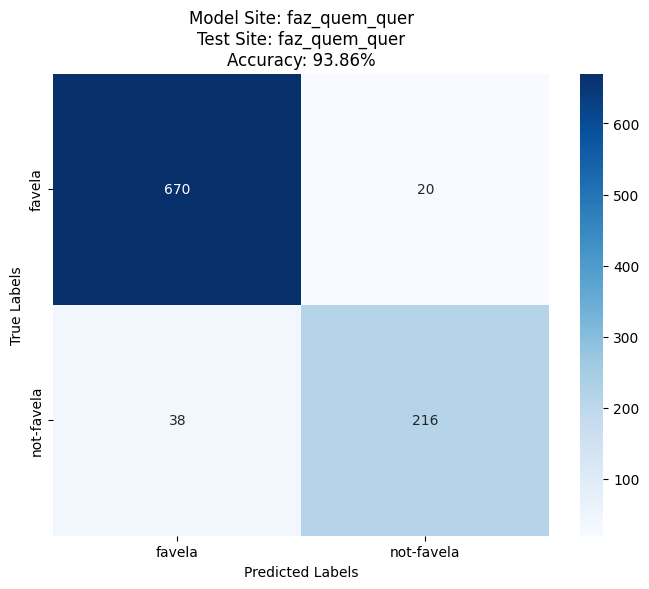

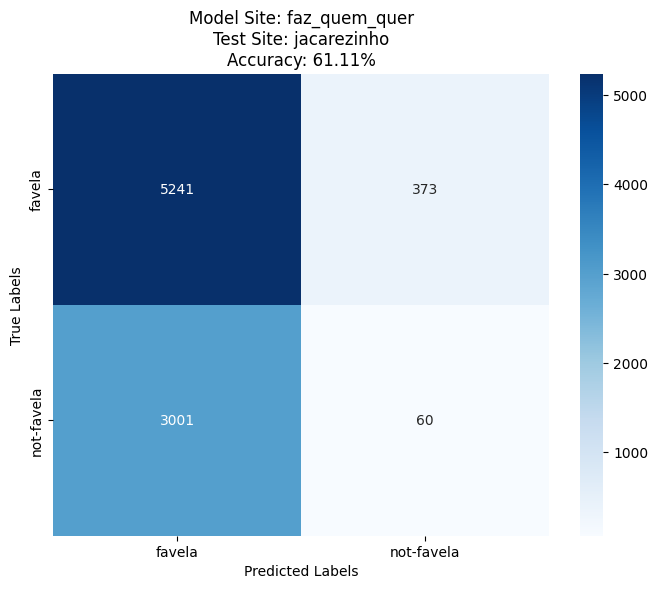

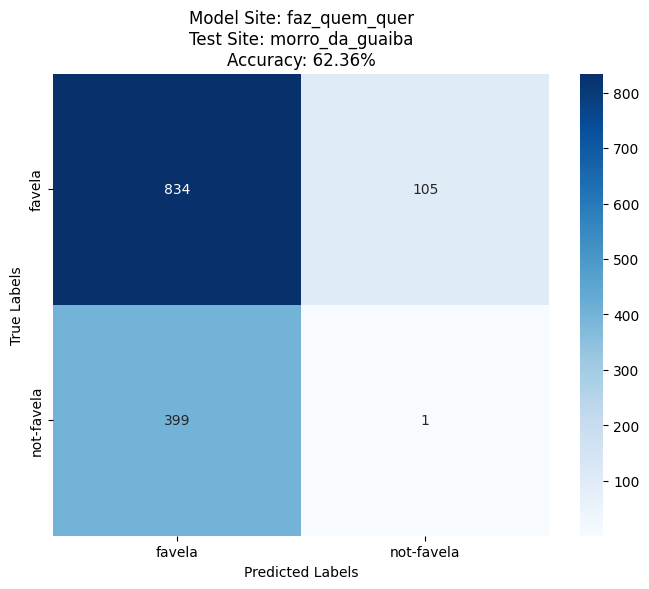

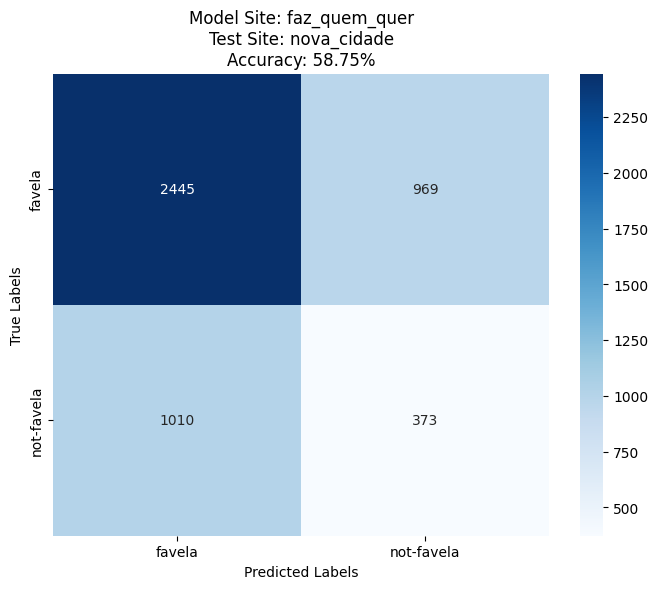

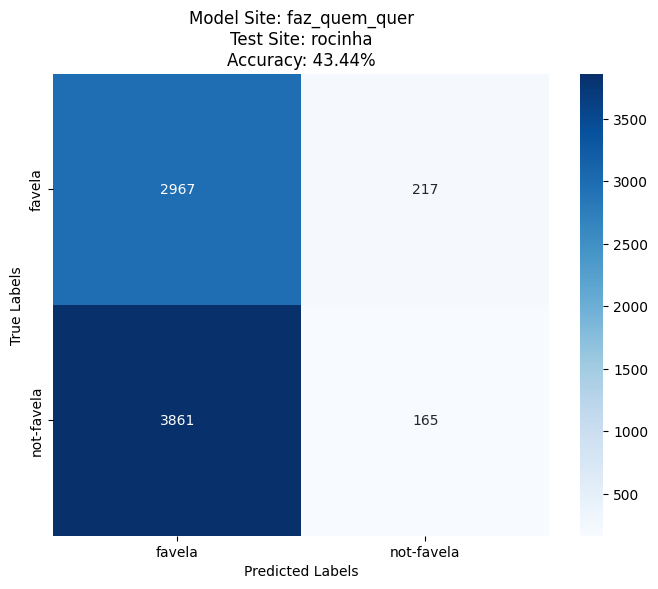

Saved cross-accuracy for 'faz_quem_quer' -> C:\Users\miles\favela_analysis\output\faz_quem_quer\faz_quem_quer_cross_accuracy_matrix.json


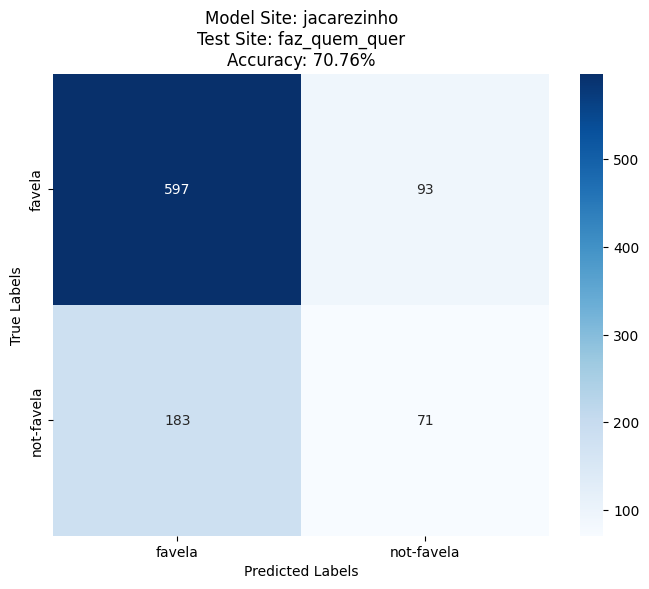

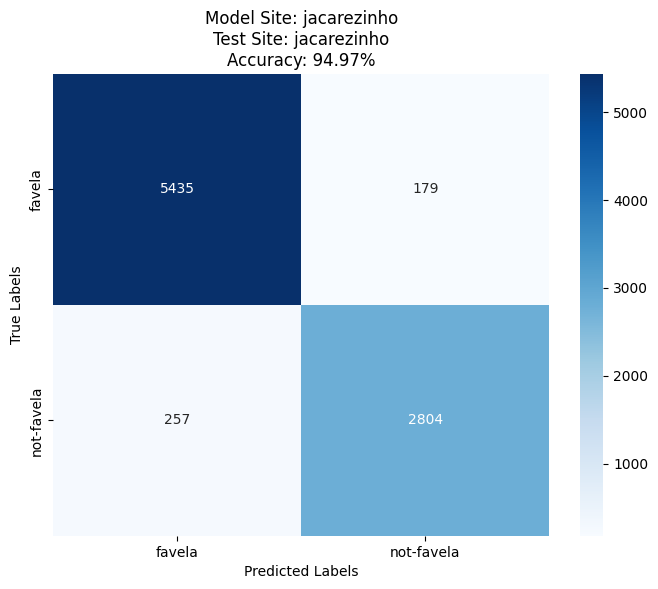

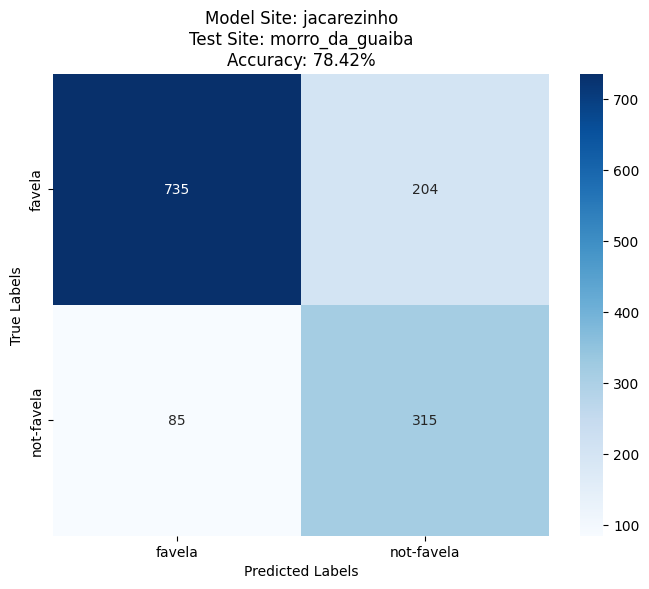

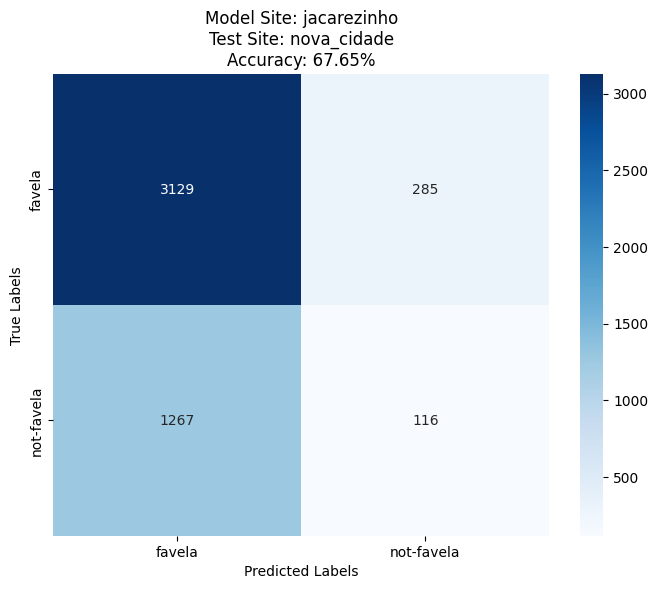

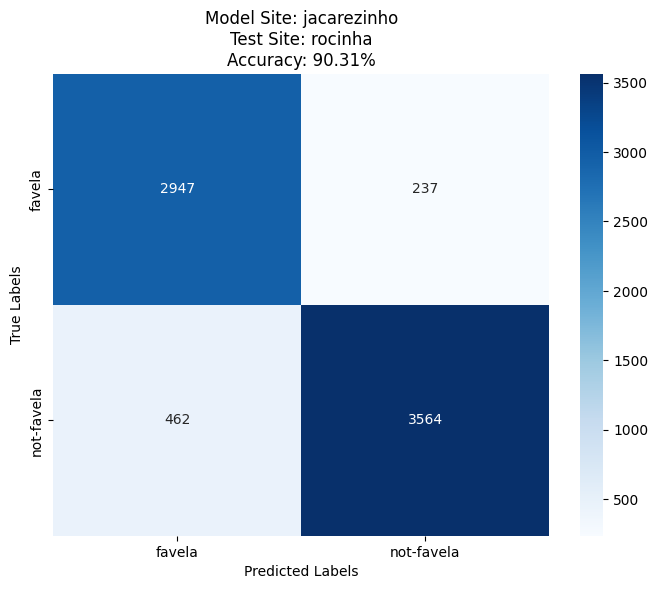

Saved cross-accuracy for 'jacarezinho' -> C:\Users\miles\favela_analysis\output\jacarezinho\jacarezinho_cross_accuracy_matrix.json


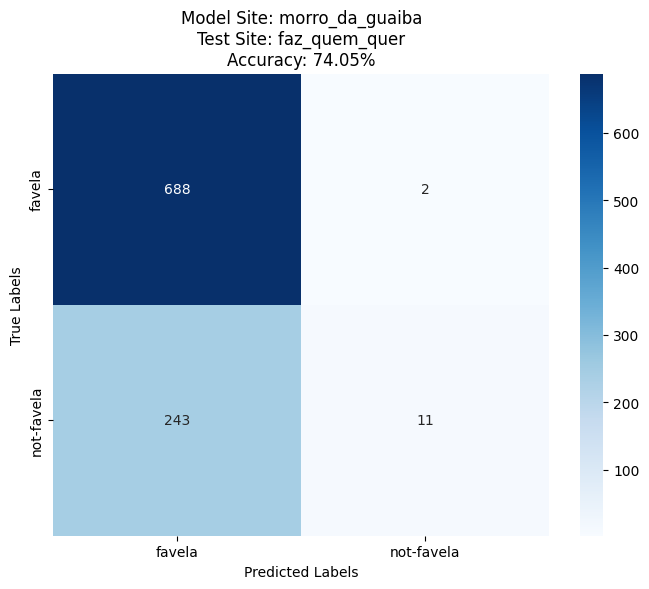

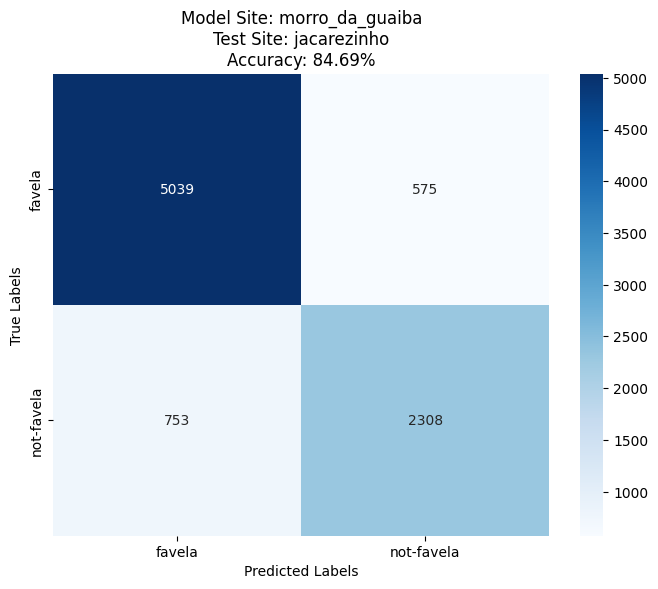

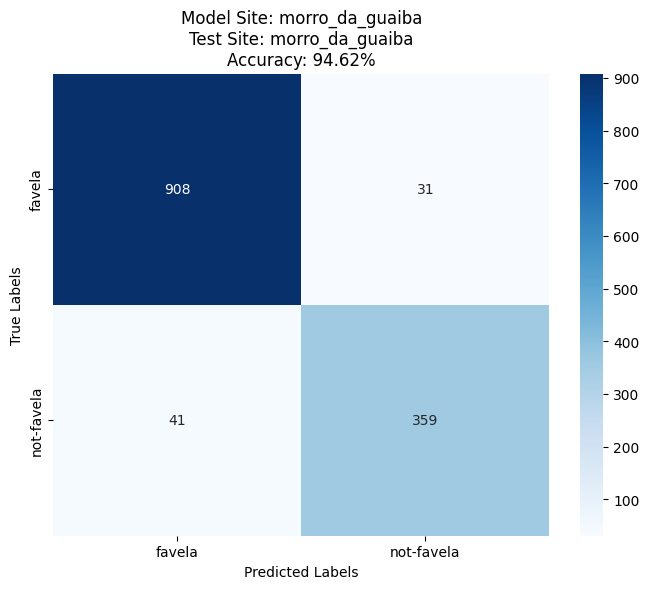

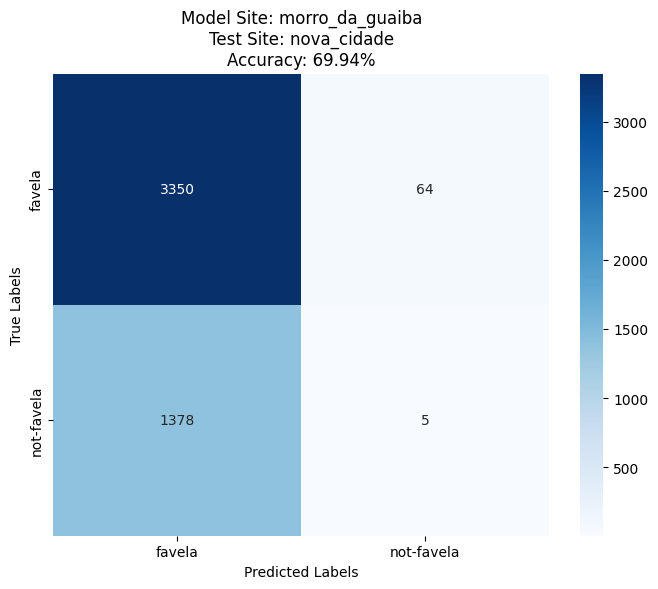

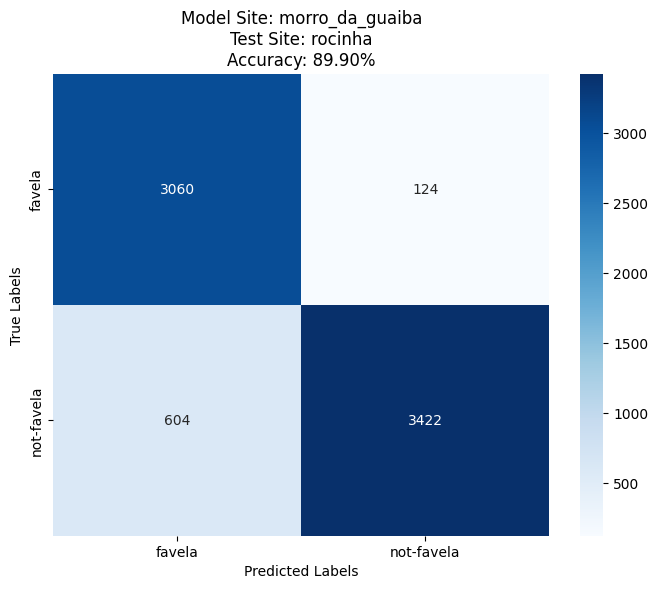

Saved cross-accuracy for 'morro_da_guaiba' -> C:\Users\miles\favela_analysis\output\morro_da_guaiba\morro_da_guaiba_cross_accuracy_matrix.json


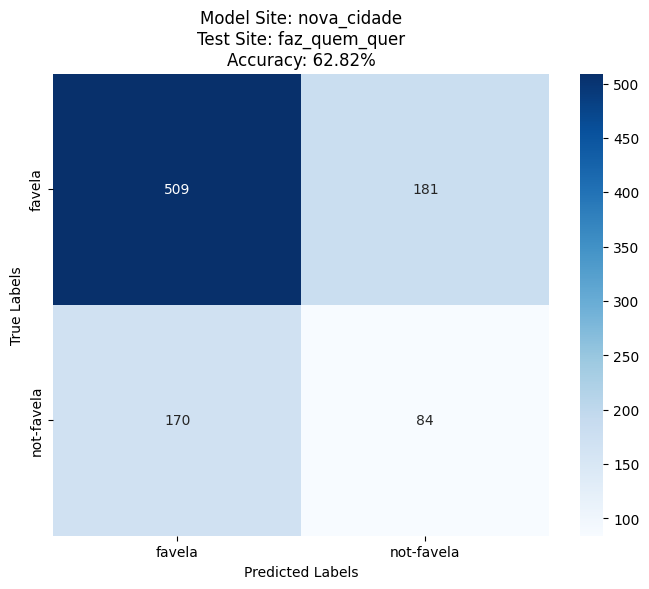

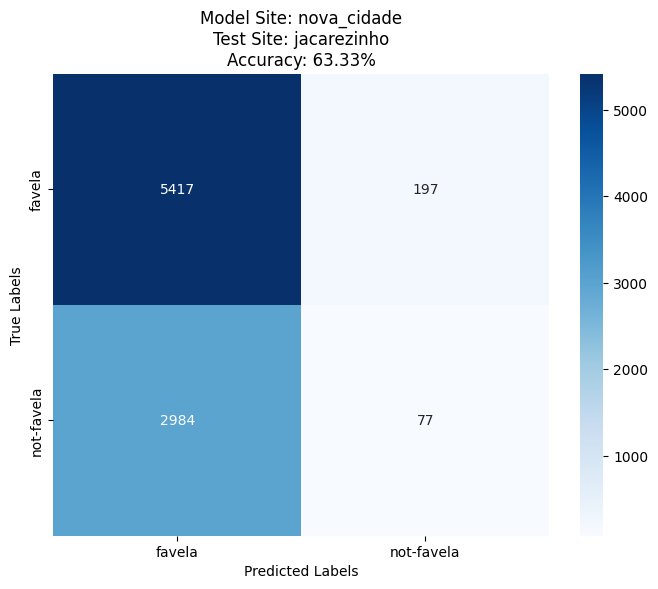

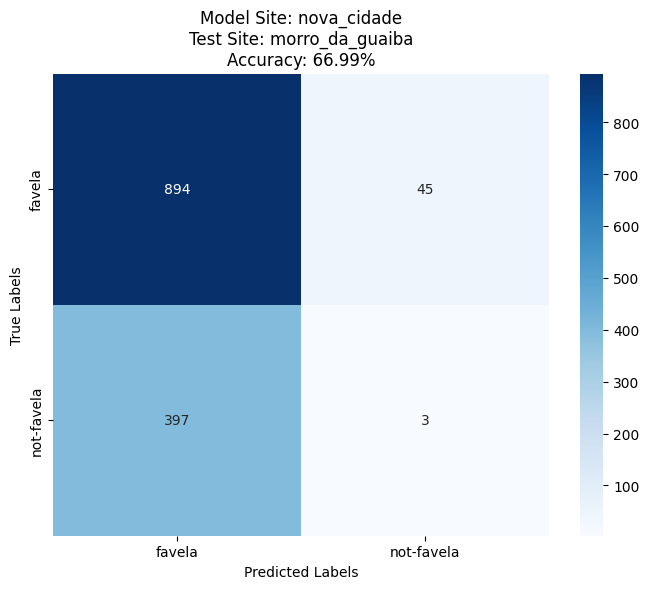

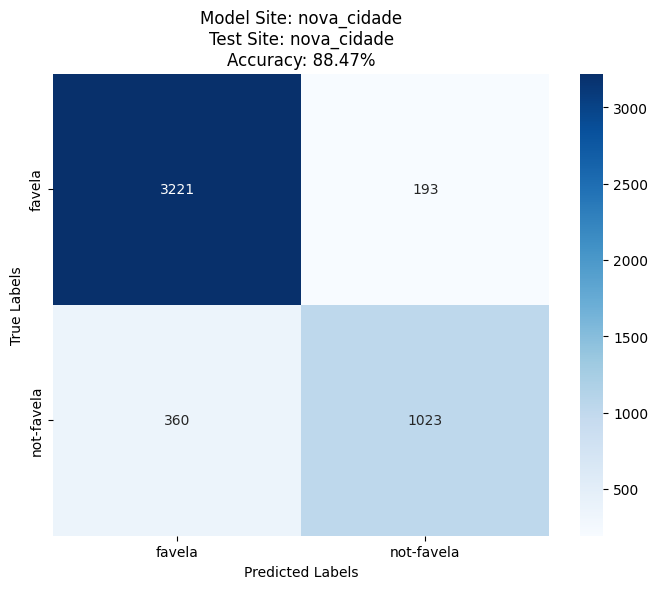

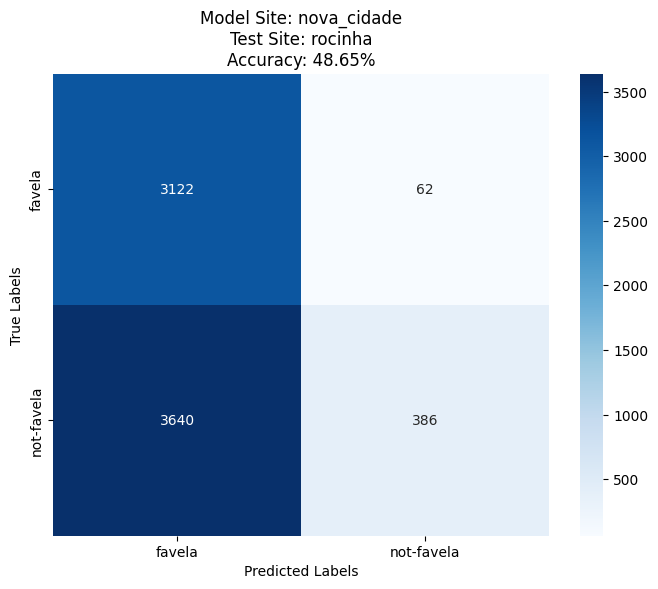

Saved cross-accuracy for 'nova_cidade' -> C:\Users\miles\favela_analysis\output\nova_cidade\nova_cidade_cross_accuracy_matrix.json


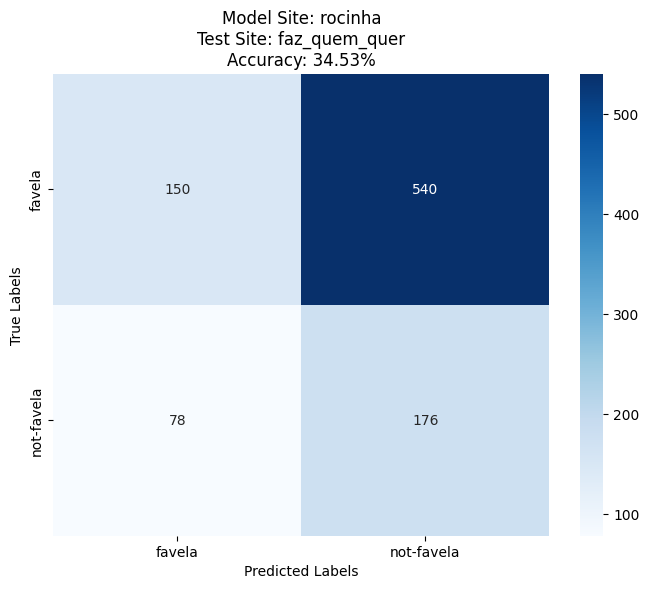

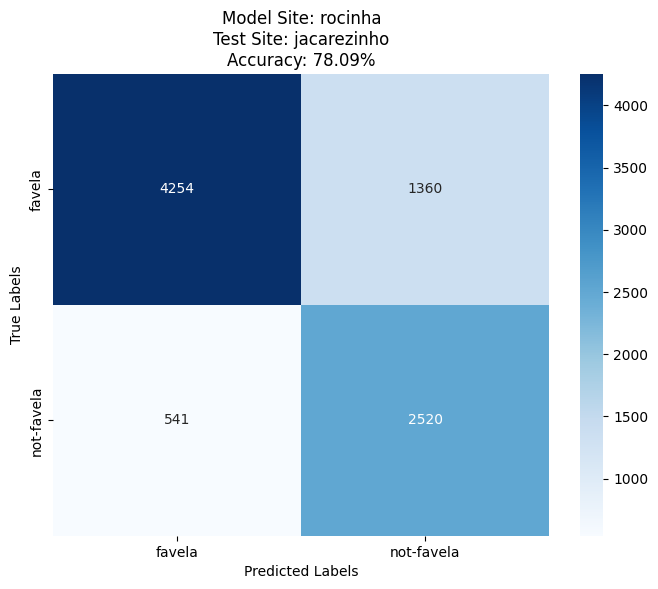

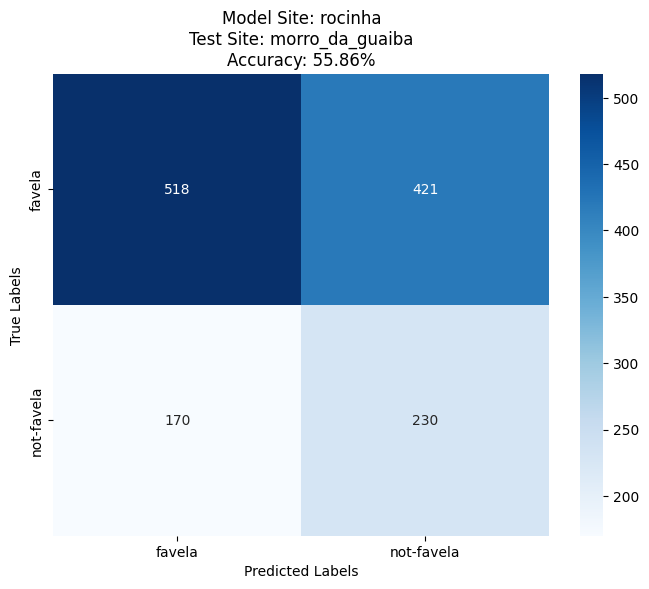

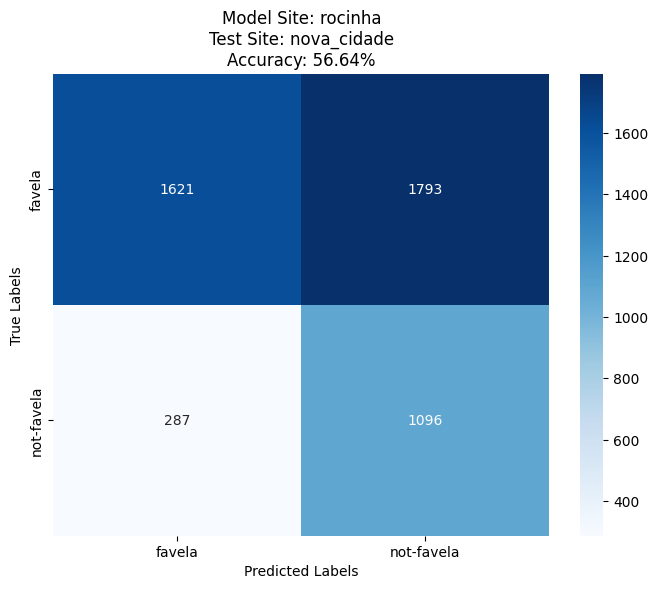

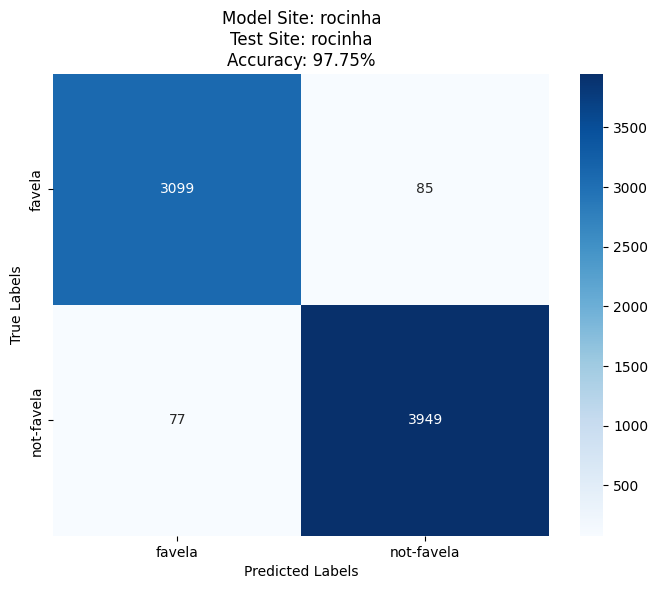

Saved cross-accuracy for 'rocinha' -> C:\Users\miles\favela_analysis\output\rocinha\rocinha_cross_accuracy_matrix.json


In [ ]:
import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def plot_confusion_matrix(y_true, y_pred, label_classes, title='Confusion Matrix'):
    """Compute and plot a confusion matrix given true labels and predictions."""
    conf_matrix = confusion_matrix(y_true, y_pred, labels=label_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=label_classes,
        yticklabels=label_classes
    )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

def cross_evaluate_models(base_path):
    """
    Loads each site's XGBoost model and label encoder, applies the model
    to every other site's test data, and prints confusion matrices.
    Saves accuracy/classification reports as JSON.
    """
    sites = [
        d for d in os.listdir(base_path)
        if os.path.isdir(os.path.join(base_path, d))
    ]

    for model_site in sites:
        model_path = os.path.join(base_path, model_site, f"{model_site}_xgb_model.json")
        label_encoder_path = os.path.join(base_path, model_site, f"{model_site}_label_encoder_classes.npy")

        if not (os.path.exists(model_path) and os.path.exists(label_encoder_path)):
            print(f"Skipping {model_site}: missing model or label encoder.")
            continue

        xgb_model = XGBClassifier()
        xgb_model.load_model(model_path)

        loaded_classes = np.load(label_encoder_path)
        label_encoder = LabelEncoder()
        label_encoder.classes_ = loaded_classes

        cross_results = {}

        for test_site in sites:
            X_test_path = os.path.join(base_path, test_site, f"{test_site}_X_test.pkl")
            y_test_path = os.path.join(base_path, test_site, f"{test_site}_y_test.npy")

            if not (os.path.exists(X_test_path) and os.path.exists(y_test_path)):
                print(f"Skipping {test_site}: missing test data.")
                continue

            with open(X_test_path, "rb") as f:
                X_test = pickle.load(f)
            y_test = np.load(y_test_path)

            # Get numeric predictions from the model
            y_pred_enc = xgb_model.predict(X_test)

            # Decode predictions and (if needed) decode true labels
            try:
                y_pred = label_encoder.inverse_transform(y_pred_enc)
            except ValueError:
                # If predictions are already strings/shape doesn't match
                y_pred = y_pred_enc

            if y_test.dtype in (np.int32, np.int64, np.float_):
                try:
                    y_test_str = label_encoder.inverse_transform(y_test)
                except ValueError:
                    y_test_str = y_test
            else:
                y_test_str = y_test

            accuracy = accuracy_score(y_test_str, y_pred) * 100
            report = classification_report(
                y_test_str,
                y_pred,
                target_names=label_encoder.classes_,
                output_dict=True
            )

            cross_results[test_site] = {
                "accuracy": accuracy,
                "classification_report": report
            }

            title = f"Model Site: {model_site}\nTest Site: {test_site}\nAccuracy: {accuracy:.2f}%"
            plot_confusion_matrix(y_test_str, y_pred, label_encoder.classes_, title=title)

        out_json = os.path.join(base_path, model_site, f"{model_site}_cross_accuracy_matrix.json")
        with open(out_json, "w", encoding="utf-8") as f:
            json.dump(cross_results, f, indent=4)

        print(f"Saved cross-accuracy for '{model_site}' -> {out_json}")

base_output_folder = r"C:\Users\miles\favela_analysis\output"
cross_evaluate_models(base_output_folder)
